## notebook configuration

In [1]:
# %load setup_notebook.py
import numpy as np
import sympy as sym
from sympy.solvers.solveset import linsolve # symbolic linear solver
import quadpy                               # quadrature rules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as mtri               # delaunay triangulation
from mpl_toolkits.mplot3d import Axes3D     # surface plotting
import seaborn as sns
from collections import defaultdict
import pdb

Upgrade to   orthopy 0.5.3    available! (installed: 0.5.0)

To disable these checks, set SecondsBetweenChecks in /Users/corbin/Library/Application Support/pipdate/config.ini to -1.



In [2]:
# config
sym.init_printing(use_latex='mathjax')      # render latex for output

## plotting
sns.set()                                   # nice plotting defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # vectorized plots instead

# 1D master element

## class definition
Define a master element class, which will hold the mass matrix, stiffness matrices, quadrature points, etc.

In [3]:
class Master1D(object):
    dim = 1
    coord = sym.Symbol('x')
    
    def __init__(self, p):
        """ basis is list of symbolic expression on [-1, 1] """
        self.verts = (-1, 1)
        self.p = p
        self.nb = self.p + 1
        self.nodes = np.linspace(self.verts[0], 
                                 self.verts[1], self.nb)
        self.basis = self.mk_nodal_basis()
        self.shape_fns = self.mk_shape_fns()
        self.D = self.mk_shape_derivatives()
        self.shape_der_fns = self.mk_shape_D_fns()
        self.M, self.K = self.mk_M(), self.mk_K()
        self.quad = self.mk_quadPts()
        self.shapq = self.eval_shape(self.quad.points) # (q, phi_i)
        
    def mk_shape_fns(self):
        vectorized_shape_fns = list()
        for sym_shape_fn in self.basis:
            fn = sym.lambdify(self.coord, sym_shape_fn, "numpy")
            vectorized_shape_fns.append(fn)
        return vectorized_shape_fns
    
    def mk_vectorized_fns(self, syms):
        vector_fns = []
        for sym_fn in syms:
            if sym_fn.is_constant():
                vector_fns.append(self.make_func(sym_fn))
            else:
                fn = sym.lambdify(self.coord, sym_fn, 'numpy')
                vector_fns.append(fn)
        return vector_fns    
    
    @staticmethod
    def make_func(sym_fn): return lambda x: np.ones_like(x) * float(sym_fn)
    def mk_shape_D_fns(self): return self.mk_vectorized_fns(self.D)
    
    def eval_shape(self, pts):
        result = np.zeros((len(pts), len(self.shape_fns)))
        for idx, fn in enumerate(self.shape_fns):
            result[:, idx] = fn(pts)
        return result.T
    
    def eval_shape_derivatives(self, pts):
        result = np.zeros((len(pts), len(self.shape_der_fns)))
        for idx, fn in enumerate(self.shape_der_fns):
            result[:, idx] = fn(pts)
        return result.T
        
    def mk_nodal_basis(self):
        monom = [self.coord ** _n for _n in range(self.nb)]
        V = self.mk_Vandermonde(monom)
        Vinv = np.linalg.inv(V)
        sym_nodal_basis = list()
        for j in range(self.nb):
            col = Vinv[:, j]
            nodal_shape_fn = 0
            for i, coeff in enumerate(col):
                nodal_shape_fn += coeff * monom[i]
            sym_nodal_basis.append(nodal_shape_fn)     
        return sym_nodal_basis
    
    def mk_Vandermonde(self, sym_basis):
        x = self.nodes
        basis_lambda_fns = [sym.lambdify(self.coord, _term) 
                            for _term in sym_basis]
        # correct first to return vector
        basis_lambda_fns[0] = lambda x: np.ones_like(x) 
        V = np.zeros((self.nb, self.nb))
        for j in range(self.nb):
            V[:, j] = basis_lambda_fns[j](x)
        return V
    
    def mk_quadPts(self):
        npts = 4 * self.p
        return quadpy.line_segment.GaussLegendre(npts)
        
    def mk_M(self):
        """ makes the mass matrix symbolically, return as floats """
        M = sym.zeros(self.nb)
        for i, psi_i in enumerate(self.basis):
            for j, psi_j in enumerate(self.basis):
                M[j,i] = sym.integrate(psi_i * psi_j, (self.coord, 
                                        self.verts[0], 
                                        self.verts[1]))
        return np.array(M).astype(np.float64)
    
    def mk_K(self):
        """ make the local laplacian matrix """
        K = sym.zeros(self.nb)
        for i, dpsi_i in enumerate(self.D):
            for j, dpsi_j in enumerate(self.D):
                K[j,i] = sym.integrate(dpsi_i * dpsi_j, 
                                       (self.coord, self.verts[0], 
                                        self.verts[1]))
        return np.array(K).astype(np.float64)  
        
    def mk_shape_derivatives(self):
        """ make derivatives of shape functions on element """
        D = sym.zeros(self.nb, 1)
        for i, psi_i in enumerate(self.basis):
            D[i, 0] = sym.diff(psi_i, self.coord)
        return D
    
    def __repr__(self):
        pstr = ''
        for key, val in self.__dict__.items():
            pstr += '{} {}\n'.format(key, val)
        return pstr 

## nodal lagrange basis

We can generate some plots of the lagrange basis created over the master element to make sure they look good. We have written the code generically, so we can do this for an arbitrarily high-order basis.

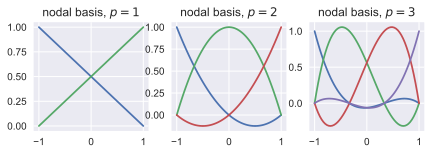

In [4]:
xx = np.linspace(-1, 1, 60)
fig, ax = plt.subplots(1, 3, figsize=(7, 2))
for axis in range(3):
    p = axis + 1
    ms = Master1D(p=p)
    basisfns = ms.shape_fns
    for idx, fn in enumerate(basisfns):
        ax[axis].plot(xx, fn(xx))
    ax[axis].set_title(r'nodal basis, $p = {}$'.format(p))
plt.show()

# FE discretization data structures

## mesh

In [5]:
class Mesh1D(object): pass

class Mesh1D_uniform(Mesh1D):
    def __init__(self, bounds, n_el):
        self.n_el = n_el
        self.xL, self.xR = bounds 
        self.L = float(self.xR - self.xL)
        self.h = self.L/n_el
        self.n_verts = self.n_el + 1
        self.verts = np.linspace(self.xL, self.xR, self.n_verts)
        self.boundary_verts = [0, len(self.verts) - 1]
        
    def __repr__(self): return '{}, {}'.format(
        self.__class__.__name__, self.__dict__.items())

## Index map `lg`, and finite element mappings

Next we need an index map function --referred to in class as the `lg` array. In order to create one of these objects, we should have a mesh object, as well as a `Master1D` object, which determines the finite element representation and nodal locations on the mesh. Since we would like a version of `lg`. Note that since we have a Neumann condition at $\Gamma_1$ and a dirichlet condition at $\Gamma_2$, we can number the nodes in an unpermuted manner, since the boundary node we're "lifting" to the RHS occurs at the end.

In [6]:
class IndexMap1D(object):
    def __init__(self, mesh1D, master1D):
        """ create index map from a Mesh1D and Master1D instance
        @param nD  number of Dirichlet DOF
        
        NOTE: number of cgnodes is mesh verts + interior nodes per elm
             where interior nodes is number of shape functions - 2 (L,R)
        """
        self.n_nodes = mesh1D.n_verts + mesh1D.n_el * (master1D.nb - 2)
        self.lg = self.create_lg(mesh1D, master1D)
        self.permute = np.arange(-1, mesh1D.n_verts - 1)
        self.permute[0] = mesh1D.n_verts - 1
        
    def create_lg(self, mesh, master):
        nodes_per_elm, elms = master.nb, mesh.n_el
        lg = np.zeros((elms, nodes_per_elm), dtype=int)
        offset = 0
        for elm in range(elms):
            lg[elm, :] = np.arange(nodes_per_elm) + offset
            offset = lg[elm, -1]
        return lg
    
    def __repr__(self): return '{}'.format(self.lg)


Next, there's the business of mapping the reference element to real space elements. We write a small class to handle fininte element mappings; in this case, we will only need the uniform one, but we can have it inherit behavior from one which can do more general affine mappings; this code will be useful in project 1.

Each class implements a function that can return $\det J$ and $J^{-1}$ of the transformation from master element to real space element. This can be queried when assembling our element-local matrices.

In [7]:
class FEMapping1D(object): pass
class FEMapping1D_Affine(FEMapping1D):
    def __init__(self, umesh, master1D):
        self.Jinv = self.mk_Jinv()
        self.detJ = self.mk_detJ()
        self.shapq = master1D.shapq
        
    def gauss_pts(self, elm=None):
        return np.dot(self.shapq.T, self.nodes(elm=elm))

        
class FEMapping1D_Uniform(FEMapping1D_Affine):
    def __init__(self, umesh, master1D):
        """ umesh is a Mesh1D_uniform instance """
        self.L = float(master1D.verts[1] - master1D.verts[0])
        self.h = umesh.h
        self.mesh = umesh
        self.master = master1D
        self.shapq = master1D.shapq
        self.J = self.mk_J()
        
    def nodes(self, elm=None):
        xL = self.mesh.xL + self.h*elm
        xR = xL + self.h
        return np.linspace(xL, xR, self.master.nb)
    
    def mk_J(self):
        """ same for all elements, so only need to iso first element
        make jacobian at quadrature points """
        xk = self.nodes(elm=0)
        shapqd = self.master.eval_shape_derivatives(self.master.quad.points)
        return np.dot(shapqd.T, xk)
    
    def cgnodes(self):
        msh = self.mesh
        n_dof = msh.n_verts + msh.n_el * (self.master.nb - 2)
        return np.linspace(msh.xL, msh.xR, n_dof)
    
    def Jinv(self, elm=None): return 1./self.J
    def detJ(self, elm=None): return self.J

# Finite element solvers

Now we have the machinery in place to start writing the finite element routines.

## routine kernels

### elemental $a(T,v)$
We would like a function to construct the element local contribution matrices $A_{el}$. Note that, __for our particular problem__ 

\begin{align}
      \frac{1}{Pe}\int_{K_m}^{} \frac{d \phi_j}{dx} \frac{d\phi_i}{dx} \, dx
      &= \frac{1}{Pe} \int_{\hat{K}}^{} \frac{d \hat{\phi}_j}{d\hat{x}} \left( \frac{d \hat{x}}{dx} \right)
        \cdot \frac{d \hat{\phi}_i}{d\hat{x}} \left( \frac{d \hat{x}}{dx} \right)
        \left| \det J \right| \, d\hat{x} \\
      &= \frac{1}{Pe} \left( \frac{d \hat{x}}{dx} \right)^2 \left| \det J \right| 
          \int_{\hat{K}}^{} \frac{d \hat{\phi}_j}{d\hat{x}} \cdot \frac{d \hat{\phi}_i}{d\hat{x}}\,
          d\hat{x} \\
      &= \frac{1}{Pe} \left( \frac{d \hat{x}}{dx} \right)^2 \left| \det J \right| \mathbb{K}
\end{align}

In [8]:
def a_el(elm, master, _map, Pe):
    """ construct the elemental A matrix, without quadrature """
    Ael = 1./Pe * _map.Jinv(elm)[0]**2 * _map.detJ(elm)[0] * master.K
    return Ael

### elemental $m(u\,T, v)$

and for the mass operator:
\begin{align}
      \frac{1}{\Delta x}\int_{K_m}^{} u \phi_j \phi_i\, dx 
      &= \frac{1}{\Delta x} \int_{\hat{K}}^{} u\widehat{\phi}_i \cdot \widehat{\phi}_j \left| \det J\right|\, d\widehat{x} \\
\end{align}

The specification of the velocity field determines how we evaluate the integral.
- if $u = U_\infty$, then this simplifies to 
    $$\int_{\hat{K}}^{} u\widehat{\phi}_i \cdot \widehat{\phi}_j  \,d\widehat{x}= \frac{U_\infty}{\Delta x} \left| \det J\right| \mathbb{M}$$

- if $u$ varies in space, then we must approximate the integral with quadrature, i.e., 

    $$
    \int_{\hat{K}}^{} u\widehat{\phi}_i \cdot \widehat{\phi}_j  \,d\widehat{x}
    \approx \sum_q w_q\, \det J\big|_{x_q}\, u_q(x_q)  \cdot \widehat{\phi}_i(\xi_q) \cdot \widehat{\phi}_j(\xi_q) 
    $$
    
    where $\xi_q = G^{-1}(x_q)$ -- the location of the quadrature points on the master element, and where we take $q = 4p$, since quadrature in 1D is cheap.

In [9]:
def m_el(elm, master, _map, u):
    """ compute m with quadrature, u is callable in space """
    xq = _map.gauss_pts(elm=elm)
    uJxW = u(xq) * _map.detJ(elm=elm) * master.quad.weights
    return np.dot(master.shapq, uJxW[:, None] * master.shapq.T)

### elemental $f(v)$

Lastly, when necessary, we can integrate a forcing function $f$ as follows:

\begin{align}
      \int_{K_m}^{} f \phi_i\, dx 
      &= \int_{\hat{K}}^{} f(G^{-1}(x)) \widehat{\phi}_i \cdot \left| \det J\right|\, d\widehat{x} \\
      &\approx \sum_{q}^{} w_q\, f(x_q) \widehat{\phi}_i(\xi_q) \left| \det J(x_q)\right| \\
\end{align}

In [10]:
def f_el(elm, master, _map, fΩ):
    """ computes the forcing integral with quadrature """
    xq = _map.gauss_pts(elm=elm)
    JxW = master.quad.weights * _map.detJ(elm=elm)
    return np.dot(master.shapq, fΩ(x=xq, elm=elm) * JxW)

### assembly routines

Next, we can use our `IndexMap1D` classes to write a generic assembly routine. The decision of which unknowns go where is handled by the `IndexMap1D` instance, so that the assembly can remain generic. Here we define the elemental matrices:

In [11]:
def A_el(elm, master, _map, Pe, u=None, Δx=None):
    """ construct the elemental A matrix, without quadrature """
    Ael = a_el(elm, master, _map, Pe)
    if u is not None:
        Ael += m_el(elm, master, _map, u) / Δx
    return Ael

def assemble_linear_system(mesh, LG, *args):
    A = np.zeros((LG.n_nodes, LG.n_nodes))
    for m in range(mesh.n_el):
        lg = LG.lg[m, :]
        A[lg[:, None], lg] += A_el(m, *args)
    return A     

def assemble_F(mesh, LG, *args):
    F = np.zeros(LG.n_nodes)
    for m in range(mesh.n_el):
        lg = LG.lg[m, :]
        F[lg] += f_el(m, *args)
    return F

## `FEM1D` implicit solver
Putting it all together, we can write a `FEM1D` code which solves the problem for one $y$ slice. Recall that for the non-dimensionalized problem, $y^*$ varies on [0,1]

In [12]:
def FEM1D(mesh, master, _map, LG, fΩ, gD, gN, Pe, u=None, Δx=None):
    
    u_D = np.asarray(gD)
    A = assemble_linear_system(mesh, LG, master, _map, Pe, u, Δx)
    F = assemble_F(mesh, LG, master, _map, fΩ)
    
    # lift Dirichlet Data to RHS
    A_N = A[:-1, :-1]
    D = A[:-1, -1]
    b = F[:-1] 
    
    # apply neumann BC to f(v), Dirichlet correction
    b[0] -= 1./Pe * gN
    b -= np.dot(D, u_D)

    # solve and reinsert dirichlet value
    sol = np.linalg.solve(A_N, b)
    xsol = np.zeros(LG.n_nodes)
    xsol[:-1] = sol
    xsol[-1] = gD
    return xsol

### 1D visualization code

We want to plot our quadratic solution as the unique quadratic interpolant, not a bunch of linear segments. We leverage the low-level scipy libraries to perform fast interpolation of our either linear or quadratic solution (as __uniquely__ specified by the nodal values).

In [13]:
from scipy.interpolate import interp1d
def plot_FEM1D_solution(ax, xx, yy, xxx, p, *args, **kwargs):
    """ xx, yy - nodal locations and values, xxx - view mesh"""
    intrp = interp1d(xx, yy, kind='quadratic') if p==2 else interp1d(xx, yy, kind='linear')
    ax.plot(xxx, intrp(xxx), *args, **kwargs)

## `FEM2D` time-stepping solver

The 2D solver incorporates backward-euler "time-stepping" in the $x$ direction; see the accompanying report for details. The "client" of this code passes spatially defined functions and problem constants to the solver, which wraps `FEM1D` in a time-stepping loop. The output is the solution, along with the mesh and finite element map, for the purposes of visualization and post-processing.

In [14]:
def FEM2D(gNfn=None, gDfn=None, w0fn=None,
          nelm=None, tgrid=None, p=None,
          ufn=None, Pe=None, f_ex=None):
    """ solves the non-dimensionalized 2D FEM problem over 0,1
    @param gN, gD  functions that take as input (x) and return the BCs
    @param w0fn  function (x, y) that compute the initial condition 
    @param f_ex  explicit forcing function taking as input (x, y)
    @param ufn  function with input x defining the velocity field in space
    """
    
    # problem discretization setup
    mesh = Mesh1D_uniform((0., 1.), nelm)
    master = Master1D(p=p)
    LG = IndexMap1D(mesh, master)
    _map = FEMapping1D_Uniform(mesh, master)

    # time marching setup
    x_idx = 1
    Δx = tgrid[x_idx] - tgrid[x_idx - 1]

    whk = w0fn(0, _map.cgnodes())
    solution = np.zeros((len(whk), steps))

    # forcing function which takes whk at quadrature points
    def fΩ(x=None, elm=None):
        α = whk[LG.lg[elm, :]]
        whk_xq = np.dot(master.shapq.T, α)
        u_xq = ufn(x)
        f = whk_xq * u_xq / Δx
        
        # if explicit forcing function
        fex = f_ex(x_current, x) if f_ex is not None else 0
        return f + fex
    
    x_current = 0
    for i in range(steps):
        solution[:, i] = whk
        
        if not np.isclose(x_current, 1.):
            Δx = tgrid[x_idx] - tgrid[x_idx - 1]
        x_current += Δx
        
        gN, gD = gNfn(x_current), gDfn(x_current)
        whk = FEM1D(mesh, master, _map, LG, fΩ, gD, gN, Pe, ufn, Δx)
        x_idx += 1

    return solution, mesh, _map

### 2D visualization code

We have some choices for how to visualize the 2D solution; however since the physics of interest for the client is the heat equation over a flat plate, it makes sense to view the solution as a 2D plot in space rather than a 1D plot animated in time.

In [15]:
def plot_FEM2D_solution_height(x, y, sol, ax, *args, **kwargs):
    """
    @param y, x vectors of y and x discretization
    @param sol  the problem solution as output by FEM2D solve
    @param ax  the current axis on which to plot
    """
    xx, yy = np.meshgrid(x, y)
    surf = ax.plot_surface(xx, yy, sol, *args, **kwargs)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    return surf

# Verification

We now have our solver codes written. Now we should verify that the routines work as expected for a small set of test problems. The approach we will use is the well-known "method of manufactured solutions." We will 
 - choose an analytical solution
 - symbolically derive the corresponding strong form problem
 - numerically solve the problem with our FEM routines to see if the solution is recovered

In [16]:
# convenience functions for symbolic derivation
def ddx(f):
    """ derivative of sympy expr f w/r/t x """
    x = sym.Symbol('x')
    return sym.diff(f, x)

def ddy(f):
    y = sym.Symbol('y')
    return sym.diff(f, y)

## 1D implicit FEM test

Before testing the 2D code, it makes sense just to test the `1DFEM` "inner loop" by itself. We test on a small spatial subproblem with strong form

\begin{align}
  0= \frac{d^2 u}{dx^2} - f_{ex}
\end{align}

where we choose $f_{ex}$ as a constant function in space. It doesn't get much simpler than this. The general solution is $u = x^2 + bx + c$ and we can symbolically determine the coefficients for any choice of boundary conditions $g_N,\, g_D$.


In [17]:
def compute_exact_solution(gD, gN): 
    x = sym.Symbol('x')
    b, c = sym.symbols('b, c')
    gen = x**2 + b*x + c

    # apply BCs to general solution
    system = []
    system.append(ddx(gen).subs(x, 0) - gN) # du/dx @ x=0 = 1
    system.append(gen.subs(x, 1) - gD)      # u     @ x=1 = 0

    coeffSolution = linsolve(system, (b, c))
    c1, c2 = next(iter(coeffSolution))
    u_exact = gen.subs([(b, c1),(c, c2)])
    u_ex = sym.lambdify(x, u_exact, 'numpy') # vectorize exact solution
    return u_exact, u_ex

To check that our 1D boundary conditions are implemented correctly, we choose an exact solution with inhomogeneous boundary conditions (both for Dirichlet and Neumann boundaries).

In [18]:
# non-dim problem
gN, gD = -1.3, 1.
u_ex_sym, u_ex = compute_exact_solution(gD, gN)
u_ex_sym

 2              
x  - 1.3⋅x + 1.3

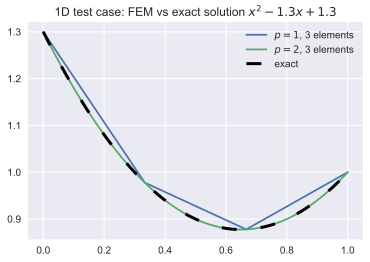

In [19]:
L = 1.0
nelm = 3
u_st = 1.
Pe, f_ex = 1., -2.
fΩ = lambda x=None, elm=None: np.ones_like(x) * f_ex

vm = np.linspace(0, L, 100) # view mesh

for p in [1, 2]:
    # make mesh, FEM data 
    mesh = Mesh1D_uniform((0., L), nelm)
    master = Master1D(p=p)
    _map = FEMapping1D_Uniform(mesh, master)
    LG = IndexMap1D(mesh, master)

    fem = FEM1D(mesh, master, _map, LG, fΩ, gD, gN, Pe)
    plot_FEM1D_solution(plt, _map.cgnodes(), fem, 
                      vm, p, '-', label=r'$p={}$, {} elements'.format(p, nelm))
plt.plot(vm, u_ex(vm), 'k--', label='exact', linewidth=3, dashes=(5, 8))
plt.legend(loc='best')
plt.title(r'1D test case: FEM vs exact solution ${}$'.format(sym.latex(u_ex_sym)))
plt.show()

The linear solution looks good and the quadratic solution matches perfectly, as we would expect, since the exact solution is an element of our finite element approximation space. We could be a bit more rigorous about measuring the error here, but we will defer that to a convergence study for the 2D case.

## 2D "temporal-discretization" test

### manufactured solution

We choose a manufactured solution which satisfies our non-dimensional equation, i.e.,
some field $w(x, y) = f(x) * g(y)$ such that

- $w(x, 1) = g_D$ (dirichlet 0 condition at $y=1$)
- $\frac{d w}{d y}(x, 0) = g_N$ (neumann flux condition)

For this, we can simply take our exact solution to the 1D test cast and multiply it by some $f(x)$, here we choose a decaying exponential $\exp(-3x)$. We then compute the analytical forcing function $f_ex$ necessary to give us our chosen analytical solution. 

For good measure, we choose a velocty profile $u(y) = y$ to test that our quadrature rules are integrating the mass operator with the velocity field well.

In [20]:
# non-dim problem
gN, gD = -1.3, 1.
u_ex_sym, u_ex = compute_exact_solution(gD, gN)

In [21]:
x, y = sym.symbols('x y')
f_x = sym.exp(-3*x)
w_ex_sym = f_x * u_ex_sym.subs(x, y)
w_ex_sym

⎛ 2              ⎞  -3⋅x
⎝y  - 1.3⋅y + 1.3⎠⋅ℯ    

In [22]:
w_ex = sym.lambdify((x, y), w_ex_sym, 'numpy')
xx = np.linspace(0, 1, 20)
X, Y = np.meshgrid(xx, xx)
Z = w_ex(X, Y)

compute artificial forcing function

In [23]:
uy = y
f_artf = uy*ddx(w_ex_sym) - ddy(ddy(w_ex_sym))
f_artf

      ⎛ 2              ⎞  -3⋅x      -3⋅x
- 3⋅y⋅⎝y  - 1.3⋅y + 1.3⎠⋅ℯ     - 2⋅ℯ    

In [24]:
f_artf = sym.lambdify((x, y), f_artf, 'numpy')

### numerical performance

In [25]:
steps=20
nelm=10

# boundary conditions for exact solution
gDfn = sym.lambdify(x, w_ex_sym.subs(y, 1)     , 'numpy')
gNfn = sym.lambdify(x, ddy(w_ex_sym).subs(y,0) , 'numpy')

# linear velocity profile function
ufn = lambda x: x

# time grid
tgrid = np.linspace(0, 1., steps)

# test on the manufactured solution
sol, msh, _map = FEM2D(gNfn=gNfn, gDfn=gDfn, 
                       w0fn=w_ex, f_ex=f_artf,
                       nelm=nelm, tgrid=tgrid,
                       ufn=ufn, Pe=1., p=2)

call our visualization code above to look at the solution and the error in the $l_\infty$ norm

In [26]:
xm = tgrid
ym = _map.cgnodes()

X, Y = np.meshgrid(xm, ym)
Z = w_ex(X, Y)

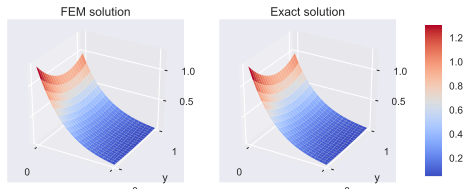

In [27]:
pltc = plt.cm.coolwarm

fig = plt.figure(figsize=(8, 3))
pltfem = fig.add_subplot(1, 2, 1, projection='3d')
plot_FEM2D_solution_height(xm, ym, sol, pltfem, cmap=pltc)
pltfem.set_title('FEM solution', y=1.07)

pltex = fig.add_subplot(1, 2, 2, projection='3d')
plot_FEM2D_solution_height(xm, ym, Z, pltex, cmap=pltc)
pltex.set_title('Exact solution', y=1.07)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
norm = mpl.colors.Normalize(vmin=np.min(Z), vmax=np.max(Z))
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=pltc,norm=norm)
plt.show()

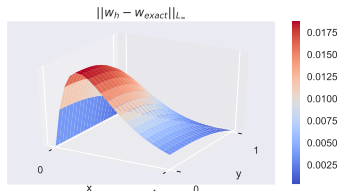

In [28]:
fig = plt.figure(figsize=(6, 3))
diff = np.abs(Z - sol)
pltdiff = fig.add_subplot(1, 1, 1, projection='3d')
surf = plot_FEM2D_solution_height(xm, ym, diff, pltdiff, cmap=pltc)
pltdiff.set_zticks([])
pltdiff.set_title(r'$\||w_h - w_{exact}\||_{L_\infty}$', y=1.08)
plt.colorbar(surf)
plt.show()


as we expect, the error is close to location corresponding to the beginning of the plate in the numerical domain. We also note that our spatial discretization is enormous overkill. Simply taking a single $p=2$ element should reproduce the exact solution for each 1D problem, since the solution of every spatial problem lies in our finite element space by construction.

In [29]:
steps=20
nelm=1

# boundary conditions for exact solution
gDfn = sym.lambdify(x, w_ex_sym.subs(y, 1)     , 'numpy')
gNfn = sym.lambdify(x, ddy(w_ex_sym).subs(y,0) , 'numpy')

# linear velocity profile function
ufn = lambda x: x

# time grid
tgrid = np.linspace(0, 1., steps)

# test on the manufactured solution
sol, msh, _map = FEM2D(gNfn=gNfn, gDfn=gDfn, 
                       w0fn=w_ex, f_ex=f_artf,
                       nelm=nelm, tgrid=tgrid,
                       ufn=ufn, Pe=1., p=2)

compute the exact solution and plot the $L_\infty$ error.

In [30]:
xm = np.linspace(0, 1., steps)
ym = _map.cgnodes()

X, Y = np.meshgrid(xm, ym)
Z = w_ex(X, Y)

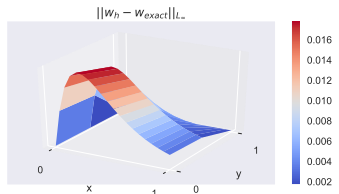

In [31]:
fig = plt.figure(figsize=(6, 3))
diff = np.abs(Z - sol)
pltdiff = fig.add_subplot(1, 1, 1, projection='3d')
surf = plot_FEM2D_solution_height(xm, ym, diff, pltdiff, cmap=pltc)
pltdiff.set_zticks([])
pltdiff.set_title(r'$\||w_h - w_{exact}\||_{L_\infty}$', y=1.08)
fig.colorbar(surf)
plt.show()

Indeed, we see the same error -- this is an indication to us that the error is almost entirely "temporal," i.e., the error in the $x$ discretization. This will be important for the temporal convergence results later on.

### variable timestep
What if we scrunch the mesh closer to x=0? This is the equivalent of taking a variable timestep.

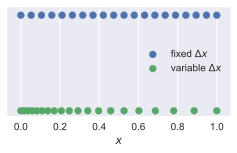

In [32]:
steps=20
tgrid = np.linspace(0, 1., steps)

def warp_grid(tgrid, warp_intensity=2):
    warped_tgrid = (np.exp(-warp_intensity*tgrid))
    warped_tgrid -= np.min(warped_tgrid)
    warped_tgrid *= 1./np.max(warped_tgrid)
    warped_tgrid = warped_tgrid[::-1]
    return warped_tgrid

warped_tgrid = warp_grid(tgrid)

fig = plt.figure(figsize=(4, 2))
plt.scatter(tgrid, np.ones_like(tgrid), label=r'fixed $\Delta x$')
plt.scatter(warped_tgrid, np.zeros_like(warped_tgrid), label=r'variable $\Delta x$')
plt.xlabel(r'$x$')
plt.yticks([])
plt.legend()
plt.show()

Because we wrote our code in a general way with respect to the `tgrid` parameter, we can simply pass the sover warped time grids and see how the solution compares.

### $L_\infty$ temporal convergence study

Since we have no spatial discretization error, we can measure temporal error to see if we can recover order 1 convergence in the $L_\infty$ norm. We can also compare how variable timestepping does against regular timesteps. __NOTE__ that we are running with $p=2$ elements where we know the spatial solution is analytically quadratic in order to make sure spatial error is unimportant.

In [33]:
gN, gD = 1., 0.
nsteps = [2, 4, 8, 16, 32, 64, 128]
nelm=1

dx, L_inf_error = list(), defaultdict(list)
for steps in nsteps:
    
    # time grid
    tgrid = np.linspace(0, 1., steps)
    wgrid = warp_grid(tgrid)
    
    for name, grid in zip(['reg', 'warped'], [tgrid, wgrid]):
        # test on the manufactured solution
        sol, msh, _map = FEM2D(gNfn=gNfn, gDfn=gDfn, 
                               w0fn=w_ex, f_ex=f_artf,
                               nelm=nelm, tgrid=grid,
                               ufn=ufn, Pe=1., p=2)
    
        X, Y = np.meshgrid(grid, _map.cgnodes())
        L_inf_error[name].append(np.max(np.abs(sol - w_ex(X, Y))))
    dx.append(1./steps)

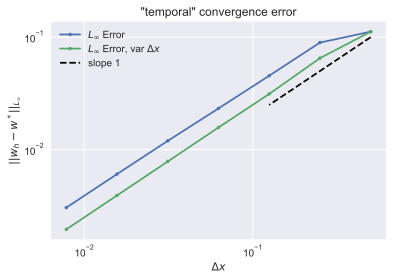

In [34]:
plt.loglog(np.asarray(dx), np.asarray(L_inf_error['reg']), 
           label=r'$L_\infty$ Error', marker='.')
plt.loglog(np.asarray(dx), np.asarray(L_inf_error['warped']), 
           label=r'$L_\infty$ Error, var $\Delta x$', marker='.')
plt.loglog([5e-1, 5e-1/4], [.1, .1/4],
            'k--', label=r'slope 1')
plt.legend()
plt.title('"temporal" convergence error')
plt.xlabel(r'$\Delta x$')
plt.ylabel(r'$||w_h - w^*||_{L_\infty}$')
plt.show()

We see that both are converging to first order in time, but that the coefficient on the error is a bit lower for the warped grid. As a word of warning, though, we can only get this nice feature because we KNEW where we expected the solution have a steep gradient in time. If we knew nothing about our problem, using the variable timestepping in this manner would not help.

It just so happens that for our client application, we expect the area of interest to be the start of the plate.

# Problem re-dimensionalization, user front-end

Finally, we are ready to define the front end between the user and the numerical solver. Specific to the physics of the heat equation problem we wish to solve (see report.pdf):

In [35]:
ufns = {'constant': lambda x: 1.*np.ones_like(x),
        'linear': lambda x: x}

def heat_eqn_ND(steps, nelm, p, Pe, utype='linear'):

    # boundary conditions for physical problem
    gDfn, gNfn = lambda x: 0., lambda x: 1.

    # linear velocity profile function
    ufn = ufns[utype]

    # time grid
    tgrid = warp_grid(np.linspace(0, 1., steps), warp_intensity=4)
    
    wT_inf = lambda x, y: np.zeros_like(y)

    # test on the manufactured solution
    sol, msh, _map = FEM2D(gNfn=gNfn, gDfn=gDfn, 
                           w0fn=wT_inf, f_ex=None,
                           nelm=nelm, tgrid=tgrid,
                           ufn=ufn, Pe=Pe, p=p)
    
    return sol, msh, _map, tgrid

The user should input to the code $L,\, U_\infty,\, q,\, T_\infty,\, \text{Pe},\, \Gamma_2$. To avoid scaling issues, we non-dimensionalize the inputs "behind the scenes" so that numerically, we can solve the non-dimensional problem instead. Now that we have the 2D solution, we would like to re-dimensionalize it so that the user is presented with something physically related to the problem they requested.

In [36]:
def dimensionalize_T(ndT, T_inf, q, L):
    return T_inf + (q*L)/k * ndT

def dimensionalize_grid(_map, tgrid, L):
    return tgrid * L, _map.cgnodes() * L

# Physical results

## thermal boundary layer: liquid mercury

In [37]:
# liquid mercury -- low Prandtl number
L     = 1.0      # meter
U_inf = 5e-2     # m/s
k     = 8.18     # W / (m deg C)
q     = -2       # W/m^2
T_inf = 25       # degrees C
μ     = 0.16e-2  # N s / m^2
ρ     = 13595    # kg/m^3
cp    = 0.1404   # J/kgK

# compute Pr number, make sure it's low
Pr = cp * μ / k
ReL = ρ * U_inf * L / μ
Pe = ReL * Pr
print('Pr: {:5.3},  Pe: {:5.3}'.format(Pr, Pe))

Pr: 2.75e-05,  Pe:  11.7


In [38]:
steps = 60
nelm = 6
p = 2

ndT_lin, msh, _map, xgrid = heat_eqn_ND(steps, nelm, p, Pe, utype='linear')
T_lin = dimensionalize_T(ndT_lin, T_inf, q, L)

ndT_Const, msh, _map, xgrid = heat_eqn_ND(steps, nelm, p, Pe, utype='constant')
T_Const = dimensionalize_T(ndT_Const, T_inf, q, L)

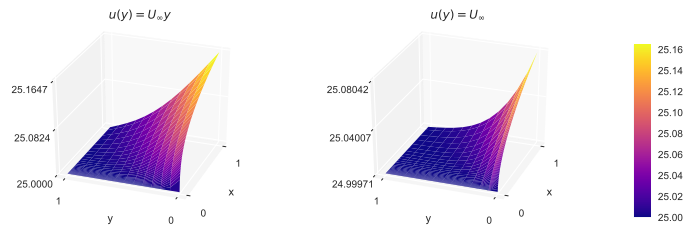

In [39]:
dim_xgrid, dim_ygrid = dimensionalize_grid(_map, xgrid, L) 
X, Y = np.meshgrid(dim_xgrid, dim_ygrid)

fig = plt.figure(figsize=(12, 4))

titles = [r'$u(y) = U_\infty y$', r'$u(y) = U_\infty$']
for i, T in zip([1, 2], [T_lin, T_Const]):
    ax = fig.add_subplot(1,2,i, projection='3d')
    surf = plot_FEM2D_solution_height(xgrid, _map.cgnodes(), T, ax,
                                      cmap=plt.cm.plasma)

    ax.view_init(30, 200)
    ax.set_zticks(np.linspace(np.min(T), np.max(T), 3))
    ax.dist=11
    ax.set_facecolor("white")
    ax.set_title(titles[i-1])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.6])
norm = mpl.colors.Normalize(vmin=np.min(T_lin), vmax=np.max(T_lin))
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.plasma,norm=norm)
plt.show()

## thermal boundary layer: molten lead


In [40]:
# molten lead -- low Prandtl number
L     = 0.8      # meter
U_inf = 2e-3     # m/s
k     = 16.1     # W / (m deg C)
q     = -20       # W/m^2
T_inf = 371      # degrees C
ν     = 2.27e-7  # m^2/s
α     = 1.08e-5  # m^2/s
cp    = 0.159e3  # J/kgK

# compute Pr number, make sure it's low
Pr = ν / α
ReL = U_inf * L / ν
Pe = ReL * Pr
print('Pr: {:5.3},  Pe: {:5.3}'.format(Pr, Pe))

Pr: 0.021,  Pe: 1.48e+02


In [41]:
steps = 60
nelm = 10
p = 2

ndT_lin, msh, _map, xgrid = heat_eqn_ND(steps, nelm, p, Pe, utype='linear')
T_lin = dimensionalize_T(ndT_lin, T_inf, q, L)

ndT_Const, msh, _map, xgrid = heat_eqn_ND(steps, nelm, p, Pe, utype='constant')
T_Const = dimensionalize_T(ndT_Const, T_inf, q, L)

Let's view our results; in this case the boundary layer is very close to the wall, so we accentuate the differences with everyones favorite non-perception-neutral colormap: `jet`.

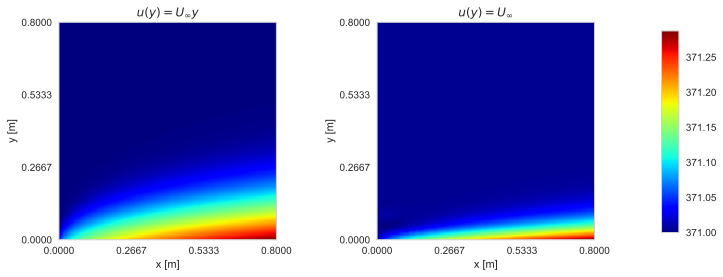

In [42]:
from scipy.interpolate import griddata
sns.set_style("whitegrid", {'axes.grid' : False})

dim_xgrid, dim_ygrid = dimensionalize_grid(_map, xgrid, L) 
X, Y = np.meshgrid(dim_xgrid, dim_ygrid)

# view mesh
xx = np.linspace(0, L, 200)
vmx, vmy = np.meshgrid(xx, xx)

fig = plt.figure(figsize=(12, 4))

titles = [r'$u(y) = U_\infty y$', r'$u(y) = U_\infty$']
for i, T in zip([1, 2], [T_lin, T_Const]):
    ax = fig.add_subplot(1,2,i)
    
    points = np.vstack((X.ravel(), Y.ravel())).T
    data = T.ravel()

    grid_interp = griddata(points, data, (vmx, vmy), method='cubic')
    ax = plt.imshow(grid_interp, extent=(0,L,0,L), origin='lower', cmap=plt.cm.jet)
    ax = fig.gca()
    plt.xticks(np.linspace(0,L,4)), ax.set_yticks(np.linspace(0,L,4))
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_title(titles[i-1])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
norm = mpl.colors.Normalize(vmin=np.min(T_lin), vmax=np.max(T_lin))
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.jet,norm=norm)
plt.show()